In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import copy
from Bio import SeqIO

from utils.similarity import merge_samples

# Outils

- **notebook** : un type de fichier permettant d'intercaler des section de code et des section de texte, permet aussi d'afficher les plots directements (pratique pour décrire une analyse)
- **pyvcf** : librairie python pour parser des fichier vcf et récupérer les variants qui y sont référencé
- **Biopython** : librairie de bioinformatique qui nous permet ici de parser le fichier fasta contenant toutes les ORF du virus
- **pandas** : Permet de traiter des donnés tabulaires (type csv) efficacement et facilement (accession, filtrage, trie, ...) dans un objet appelé data_nf1Frame
- **seaborn** : Permet de réaliser des graphiques facilement à partir de DataFrame

# Récupération des données

Les variants structuraux de tous les échantillons pour tous les passage ont été récupérés au préalable sur le cluster et regroupés dans un fichier csv. Chaque variants est représenté par une donné avec les entrées suivantes:

- **id** : identifiant de la variation dans le fichier vcf
- **svtype** : type de variant (INS, DEL, INV, DUP)
- **pos** : position de début de la variation
- **end** : position de fin de la variation (pour une insertion pos = end)
- **svlen** : taille de la variation (négatif pour les délétions)
- **alt** : séquence du variant en cas d'insertion
- **dr, dv** : profondeur de read mappant sur la référence (dr) et mappant sur le variant (dv)
- **depth** : profondeur de read total sur cette région du génome (dr + dv)
- **af** : fréquence allélique ( dv / depth : proportion de read supportant cette inversion par rapport au reads mappés sur cette région)
- **sample** : échantillon d'origine (1 à 10)
- **iteration** : passage d'origine (15 à 90)
- **group** : les variants identiques sont regroupés avec un identifiant identique (voir ci dessous)

## Groupement des variants identiques

On veut pouvoir repérer les différentes occurences d'un même variant dans différentes expériences.
Pour cela les variants sont comparé entre eux en se basant sur les éléments suivants, qui doivent être identiques :
- La position de début
- La position de fin 
- La séquence alternative pour les insertions

Il a été choisis de grouper les variants seulement lorsqu'ils sont exactement identique pour être certain qu'ils ont le même impacte sur le fonctionnement biologique. Par ailleurs, cette méthode identifie de nombreuses occurences d'un même variant, ce qui montre que ce seuil est pertinent : pour 2 457 variants, 779 groupes ont été identifiés.

Il est possible de baisser le seuild de similarité pour grouper des variants proche même si ils ne sont pas identiques. Dans ce cas la les deux variants sont "alignés" position à position pour comparer le pourcentage de bases identiques, à la même position : par exemple si une insertion commence à la position 0 et une autre commence à la potition 5 on alignera comme ci dessous:

ATCGCCTGCT-------\
-----AGCCCAGATTAT

Nous avons remarqué que, a priori, baisser le seuil de similarité (même à 0.99) peut être particulièrement intéressant pour grouper les très grands variants. En effet l'insertion géante de l'ORF25 en particulier, est récurrente dans chaque échantillon mais sa position peut varier de quelques bases : elle n'est donc pas toujours identique, malgrès une très forte similarité.

**Remarque :** La valeur de similarié peut être adapté dans ce script en modifiant la variable sim_thresold ci dessous


In [2]:
sim_thresold = 1

data = pd.read_csv('../data/variants.csv', index_col="index").to_dict('records')
grouped = merge_samples(data, 1)
flat_grouped = []
for i, g in enumerate(grouped):
    for v in g:
        v["group"] = i
        flat_grouped.append(v)

data = pd.DataFrame(flat_grouped)

print(f"Avec un seuil de similarité à {sim_thresold} : {len(data["group"].unique())} groupes identifiés sur {len(data)} variants")

Avec un seuil de similarité à 1 : 780 groupes identifiés sur 2457 variants


In [3]:
# Catégorisation des colonnes 
data["iteration"] = pd.Categorical(data["iteration"])
data["sample"] = pd.Categorical(data["sample"])
data["group"] = pd.Categorical(data["group"])
data["svtype"] = pd.Categorical(data["svtype"])

# Précalcul de dcertaines donnés pour un accès plus simple
data["choc"] = pd.Categorical(data.apply(lambda x: "cold" if x["sample"] <= 5 else "heat", axis=1))
data["period"] = pd.Categorical(data.apply(lambda x: "before" if x["iteration"] == 15 else ("choc" if x["iteration"] == 30 else "after"), axis=1))

samples = data["sample"].astype(int).unique()
samples.sort()
iterations = data["iteration"].astype(int).unique()
iterations.sort()
chocs = ["cold", "heat"]
periods = ["before", "choc", "after"]

# Copy du jeu de données avants les filtres
data_init = pd.DataFrame(
    columns = data.columns, data = copy.deepcopy(data.values)
)
data_init["iteration"] = pd.Categorical(data["iteration"])
data_init["sample"] = pd.Categorical(data["sample"])
data_init["group"] = pd.Categorical(data["group"])
data_init["svtype"] = pd.Categorical(data["svtype"])

data.head()

,pos,id,svtype,svlen,end,af,dv,dr,depth,alt,ref,sample,iteration,group,choc,period
0,1,Sniffles2.DUP.705S0,DUP,272677,272678,0.0,0,0,0,<DUP>,N,1,15,0,cold,before
1,1,Sniffles2.DUP.3B3S0,DUP,272677,272678,0.0,0,0,0,<DUP>,N,1,30,0,cold,choc
2,1,Sniffles2.DUP.29FS0,DUP,272677,272678,0.0,0,0,0,<DUP>,N,1,50,0,cold,after
3,1,Sniffles2.DUP.6ADS0,DUP,272677,272678,0.0,0,0,0,<DUP>,N,2,15,0,cold,before
4,1,Sniffles2.DUP.1AS0,DUP,272677,272678,0.0,0,0,0,<DUP>,N,2,30,0,cold,choc


# Filtrage des données

## Fréquence allélique et profondeur

Pour déterminer des filtres de fréquences alléliques et de profondeur minimum qui soit pertinent on regarde quelles sont les valeurs observés dans les différents passage. Il est nécessaire de regarder tous les passages indépendament puisque la qualité globale du séquencage diffère d'un passage à l'autre. On choisiras cependant un seuil fixe pour l'ensemble des passage afin de rester consistant.

Pour les fréquences allélique, on voit sur l'histogramme on remarque une démarquation à 0.05 (ligne rouge): comme une grande quantité d'observations se situe en dessous de ce seuil, il est pertinent de considérer que ces observations sont les moins significatives.

Ce raisonnement est plus compliqué à appliquer sur les profondeur qui ne sont pas aussi distinctement répartis, on peut afficher des violin plots pour voir la distribution de chaque passage. La largeur du graphique représente la proportion de reads à une valeur donnée de profondeur, un boxplot est représenté à l'interieur en noir. On voit qu'avec un filtre à 1100 on écarte moins de 25% des variants, cette valeur semble pertinente.

Le dernier graphique représente chaque variant par un point positioné en fonction de sa profondeur (absysses) sa fréquence allélique (ordonnées).

Enfin avec des seuils à 0.05 et 1100 on conservera des variants supportés par 55 reads minimum ce qui est significatif (0.05 * 1100).

**Remarque :** ce sont les groupes de variants (cf description plus haut) identiques qui sont filtrés et non les variants individuellement, par exemple si un variant est présent à P15 et ne remplis pas les conditions pour passer le filtre, mais qu'il est aussi présent à P50, cette fois en fréquence et en profondeur suffisante, les deux occurences seront conservé. En effet cela nous donne un information plus pertinentes sur les variants et nous permets de considérer les différents passages ensembles. On affiche donc les fréquences maximale pour chaque groupe de variants identiques.

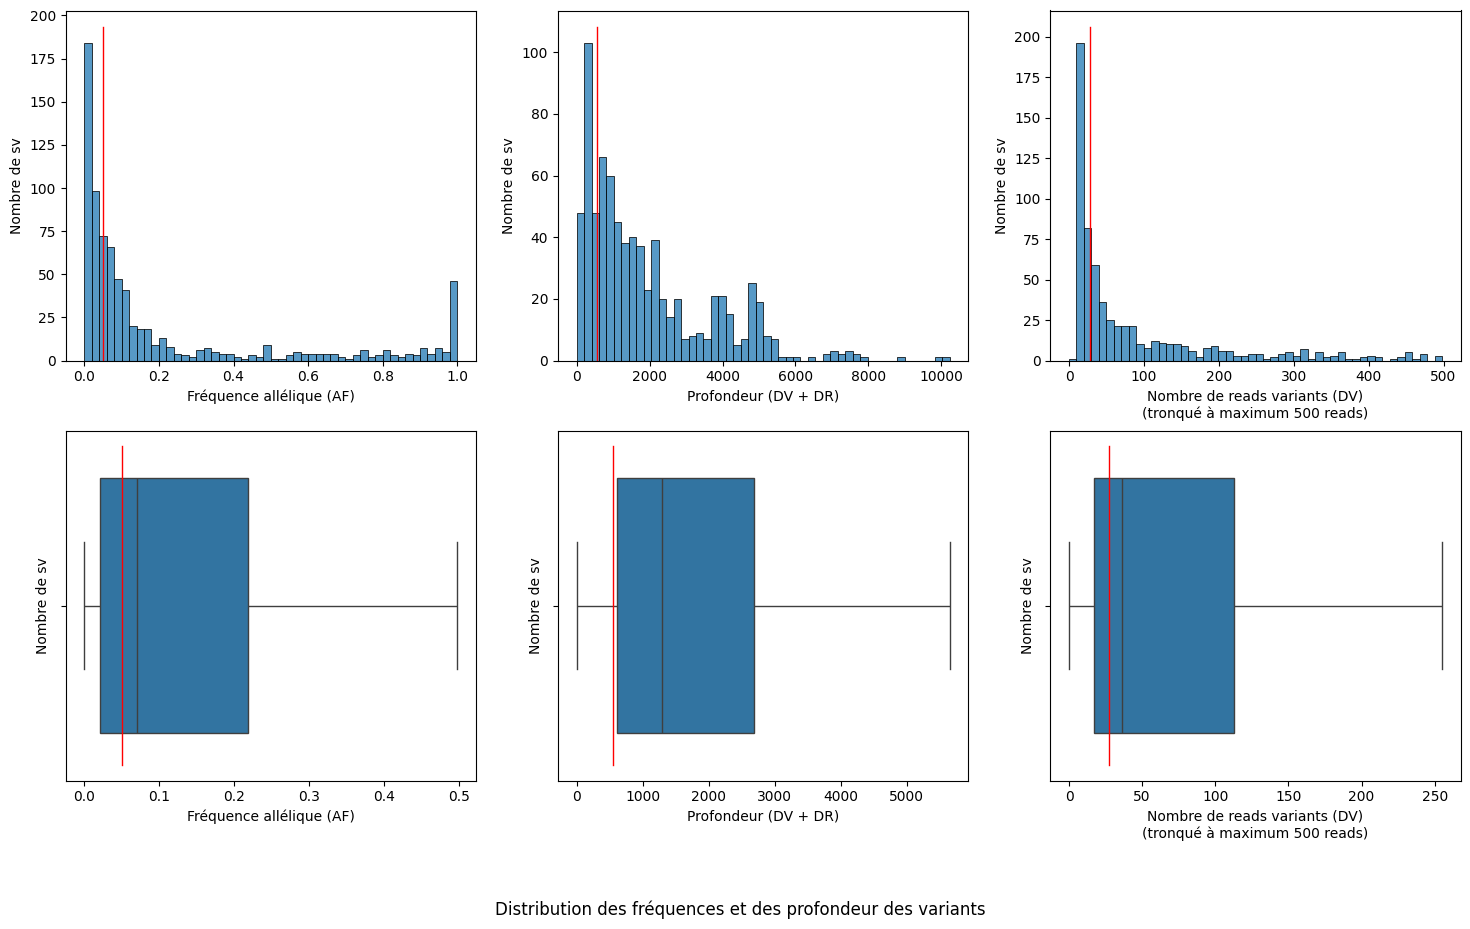

In [4]:
fig, (r1, r2) = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
ax1, ax2, ax3 = r1
ax4, ax5, ax6 = r2

data_max_dv = data_init.sort_values('dv', ascending=False).drop_duplicates(['group'])

freq_lim = 0.05
depth_lim = 550
dv_lim = freq_lim * depth_lim

# Fréquence
sns.histplot(data=data_max_dv, x="af", bins=50, ax=ax1)
ax1.set_xlabel("Fréquence allélique (AF)")
ax1.set_ylabel("Nombre de sv")

sns.boxplot(data=data_max_dv, x="af", ax=ax4, showfliers=False)
ax4.set_xlabel("Fréquence allélique (AF)")
ax4.set_ylabel("Nombre de sv")

ax1.plot([freq_lim, freq_lim], [ax1.get_ylim()[0], ax1.get_ylim()[1]], 'r-', lw=1)
ax4.plot([freq_lim, freq_lim], [ax4.get_ylim()[0], ax4.get_ylim()[1]], 'r-', lw=1)

# Depth
sns.histplot(data=data_max_dv, x="depth", bins=50, ax=ax2)
ax2.set_xlabel("Profondeur (DV + DR)")
ax2.set_ylabel("Nombre de sv")

sns.boxplot(data=data_max_dv, x="depth", ax=ax5, showfliers=False)
ax5.set_xlabel("Profondeur (DV + DR)")
ax5.set_ylabel("Nombre de sv")

ax2.plot([depth_lim, depth_lim], [ax2.get_ylim()[0], ax2.get_ylim()[1]], 'r-', lw=1)
ax5.plot([depth_lim, depth_lim], [ax5.get_ylim()[0], ax5.get_ylim()[1]], 'r-', lw=1)

# DV
sns.histplot(data=data_max_dv[data_max_dv["dv"] <= 500], x="dv", bins=50, ax=ax3)
ax3.set_xlabel("Nombre de reads variants (DV)\n(tronqué à maximum 500 reads)")
ax3.set_ylabel("Nombre de sv")

sns.boxplot(data=data_max_dv[data_max_dv["dv"] <= 500], x="dv", ax=ax6, showfliers=False)
ax6.set_xlabel("Nombre de reads variants (DV)\n(tronqué à maximum 500 reads)")
ax6.set_ylabel("Nombre de sv")

ax3.plot([dv_lim, dv_lim], [ax3.get_ylim()[0], ax3.get_ylim()[1]], 'r-', lw=1)
ax6.plot([dv_lim, dv_lim], [ax6.get_ylim()[0], ax6.get_ylim()[1]], 'r-', lw=1)


#sns.scatterplot(data=data_max_dv[(data_max_dv["iteration"].isin([90, 15, 65, 30, 50])) & (data_max_dv["depth"] > 50)], x="max_depth", y="max_af", ax=ax3)
#ax3.plot([ax3.get_xlim()[0], ax3.get_xlim()[1]], [0.05, 0.05], 'r-', lw=1)
#ax3.plot([1100.0, 1100.0], [ax3.get_ylim()[0], ax3.get_ylim()[1]], 'r-', lw=1)
#ax3.set_xlabel("Profondeur de l'alignement maximale")
#ax3.set_ylabel("Fréquence allélique maximale")
#ax3.set_yscale("log")
#ax3.set_xscale("log")

plt.suptitle("Distribution des fréquences et des profondeur des variants", y=-0.01)
plt.show()
#plt.savefig("../results/figs/choose_filter.pdf")

**Remarque :** On peut ci dessous choisir les filtres filter_af et filter_depth pour changer les seuils

In [5]:
filter_af = 0.05
filter_depth = 550
filter_dv = int(filter_af * filter_depth)

passed = data_max_dv[(data_max_dv["af"] >= filter_af) & (data_max_dv["depth"] >= filter_depth)]["group"].values
data = data[data["group"].isin(passed)]

## Repérer les outliers

Des outliers sont des données inattendu qui peuvent possiblement être causé par des bugs. Dans notre cas on sait que les régions au début et à la fin du génome sont répétés, ce qui peut conduire à détecter de larges insertions dans ces régions.
Afficher la distribution des longueurs de variants dans un box plot nous permet de les repérer pour les filtrer correctement. 

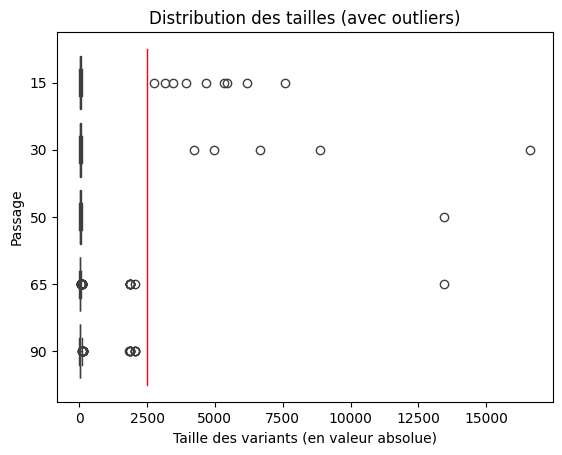

In [6]:
fig, ax = plt.subplots()
data_filt = data_init.groupby(["group"], observed=True).filter(lambda x: x["af"].max() > filter_af and x["depth"].max() > filter_depth)
sns.boxplot(data=data_filt[(30000 < data_filt["pos"]) & (data_filt["pos"] < 270000)], x=abs(data_filt[(30000 < data_filt["pos"]) & (data_filt["pos"] < 270000)]["svlen"]), y="iteration", showfliers=True, ax=ax)
ax.set_xlabel("Taille des variants (en valeur absolue)")
ax.set_ylabel("Passage")
ax.set_title("Distribution des tailles (avec outliers)")

plt.plot([2500.0, 2500.0], [ax.get_ylim()[0], ax.get_ylim()[1]], 'r-', lw=1)
plt.show()

En observant plus en détails ces donnés on remarque que soit ces variants sont positionnés au bornes du génomes, soit ce sont des régions répétés.
Ci dessous tous les variants d'une taille superieur à 2 500 entre les positions 20 000 et 280 000.

On décidera donc de filtrer les variants qui ont une taille supérieur à 2 500.

In [7]:
def truncate(x):
    if x["svtype"] == "INS":
        x["alt"] = x["alt"][max(len(x["alt"]) - 20, 0):] 
    return x

outliers = data.copy(deep=True)
outliers["svlen"] = abs(outliers["svlen"])
outliers = outliers[(outliers["svlen"] > 2500) & (outliers["pos"] > 20000) & (outliers["pos"] < 280000)]
outliers = outliers.sort_values("pos").sort_values("svlen", ascending=False)

outliers = outliers.apply(truncate, 1)
outliers[["svlen", "pos", "alt"]]

,svlen,pos,alt
1774,16622,196282,AAAAAAAAAAAAAAAAAAAA
1333,8855,138818,CTCAACTGTCGTGCCGTTGA
1082,7568,85419,GGGGGGGGGGCGCTATGTGG
1447,6668,155479,CTCTGGGGCTGAGCGGGAGA
1334,6168,142608,GGGGGGGGGGGGGGGGGGGG
303,5867,22914,GAGAGAGAGAGAGAGAGAGA
1267,5459,122251,GGGGGGGGGGGGGGGGGGGG
1268,5353,122357,AAAGCACACACACACACACA
848,4977,54238,GGGGGGGGGGGGGGGGGGGG
2175,4667,250730,CCCCCCCCCCCCCCCCCCCC


**Remarque :** La variable max_len ci dessous permet de choisir la taille maximal des variants conservés.

In [8]:
max_len = 2500
data = data[abs(data["svlen"]) < max_len]

## Impacte du filtrage

On superpose les données aux différentes étapes du filtrage pour comprendre l'impacte et voir la quantité de données conservés. Contrairement au graphique qu'on à fait au début on considère ici chaque variant indépendament, cela permet de rendre compte de la quantité de variants qui ont été filtrés.

Proportion de variants conservés : 0.7232397232397232


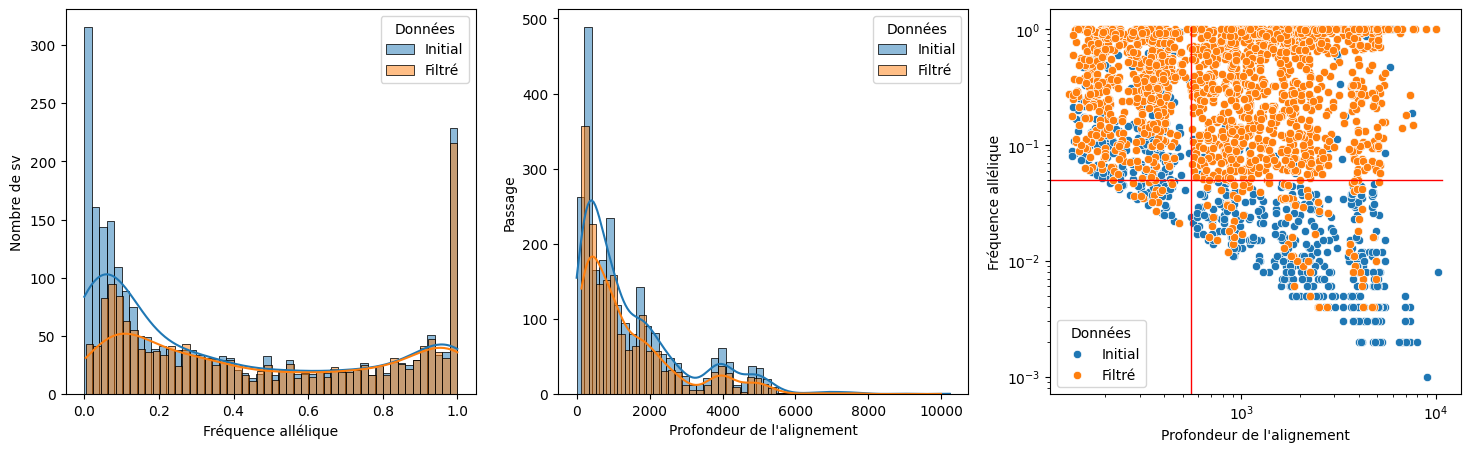

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

sns.histplot(data=data_init, x="af", label="Initial", kde=True, bins=50, ax=ax1)
sns.histplot(data=data, x="af", label="Filtré", kde=True, bins=50, ax=ax1)
ax1.set_xlabel("Fréquence allélique")
ax1.set_ylabel("Nombre de sv")
ax1.legend(title="Données")

sns.histplot(data=data_init, x="depth", label="Initial", kde=True, bins=50, ax=ax2)
sns.histplot(data=data, x="depth", label="Filtré", kde=True, bins=50, ax=ax2)
ax2.legend(title="Données")

sns.scatterplot(data=data_init[(data_init["depth"] > 50)], x="depth", y="af", label="Initial", ax=ax3)
sns.scatterplot(data=data[(data["depth"] > 50)], x="depth", y="af", label="Filtré", ax=ax3)
ax2.set_xlabel("Profondeur de l'alignement")
ax2.set_ylabel("Passage")
ax3.legend(title="Données")


ax3.plot([ax3.get_xlim()[0], ax3.get_xlim()[1]], [filter_af, filter_af], 'r-', lw=1)
ax3.plot([filter_depth, filter_depth], [ax3.get_ylim()[0], ax3.get_ylim()[1]], 'r-', lw=1)
ax3.set_xlabel("Profondeur de l'alignement")
ax3.set_ylabel("Fréquence allélique")
ax3.set_yscale("log")
ax3.set_xscale("log")

print("Proportion de variants conservés :", len(data)/len(data_init))
plt.show()
#plt.savefig("res_filter.pdf")

## Extraire les variants qui interfèrent avec un ORF connu

Pour cela on extrait tous les ORFs connues du virues à partir d'un fichier FASTA. Si une variation structurelle chevauche un ou plusieurs ORFs, on noteras lesquel.

In [10]:
orfs = []

for seq in SeqIO.parse("../data/ORF.fasta", "fasta"):
    header = seq.description

    locus_tag = header.split("[")[1][:-2].split("=")[1]
    protein_id = header.split("[")[4][:-2].split("=")[1]

    locations = header.split("[")[5][:-2].split("(")[-1].split("=")[-1].split(")")[0].split(",")
    locations = [inter.split("..") for inter in locations]

    complement = 'complement' in header.split("[")[5]
    join = 'join' in header.split("[")[5]

    to_add = [{'locus_tag': locus_tag, 'protein_id': protein_id, 'location': loc, 'complement': complement, 'join': join} for loc in locations]
    orfs += to_add


def intersected_orfs(pos, end, type):
    result = []
    for o in orfs:
        if type == "INS" and pos > int(o["location"][0]) and pos < int(o["location"][1]):
            result.append(o["locus_tag"])
        elif type != "INS" and min(end, int(o["location"][1])) - max(pos, int(o["location"][0])) > 0:
            result.append(o["locus_tag"])
    return result

In [11]:
data["orfs"] = data.apply(lambda x: intersected_orfs(x["pos"], x["end"], x["svtype"]), axis=1)
data[data["orfs"].astype(bool)][["id", "orfs"]].head()

,id,orfs
54,Sniffles2.DEL.1D5S0,[CyHV3_ORF5_1]
140,Sniffles2.INS.35S0,[CyHV3_ORF7_1]
304,Sniffles2.INS.1FS0,[CyHV3_ORF11]
305,Sniffles2.INS.45S0,[CyHV3_ORF11]
306,Sniffles2.INS.6AS0,[CyHV3_ORF11]


# Exploration de P90

**Remarque :** Le code suivant peut être appliqué aux autres passages simplement en changant la variale ioi

In [12]:
ioi = 90 # Iteration of interests

data_ioi = data[data["iteration"] == ioi]
data_ioi_orf = data_ioi[data_ioi["orfs"].astype(bool)]

## Distributions des variants

On veut d'abord mener une analyse descriptive pour voir les différents variants qui compose les échantillons du passage P90, leur quantités, leurs positions et leur tailles.

On remarque que les échalntillons du choc chaud sont beaucoup plus riche en délétion (3ème plot) alors que le nombre d'insertions reste très stable entre les différents échantillons (2ème plot). Le nombre d'insertion étonnament proche entre le groupe chaud et froid nous laisse penser que ce pourrait être les mêmes insertions. À ce stade on peut supposer que les délétions sont plus corrélés au choc thermique que les insertions, elles ont pu être sélectionnés dasn le chaud ou éliminés dans le froid.

Si on suppose que la probabilité d'apparition d'une insertion et d'une délétions sont identiques (est ce que c'est vrai ?), on pourrait alors imaginer que les délétions sont contre-sélectionnés par le choc froid, donc ont un effet délétaire pour ce groupe.

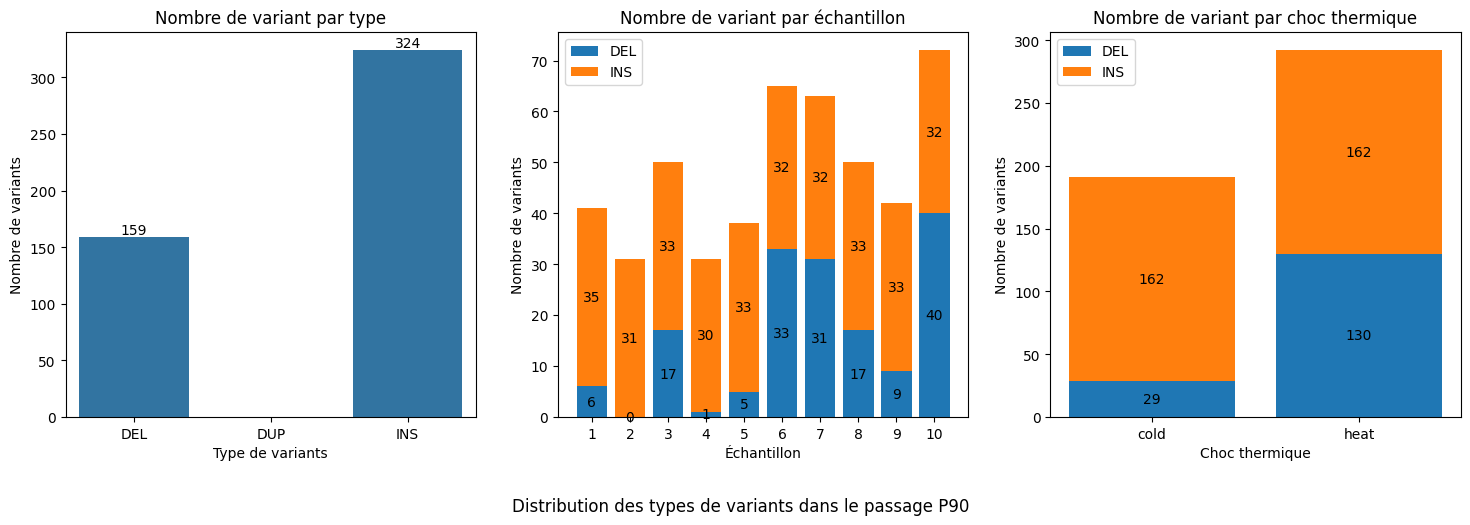

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

sns.countplot(data=data_ioi, x="svtype", ax=ax1)
ax1.bar_label(container = ax1.containers[0], fontsize=10)
ax1.set_ylabel('Nombre de variants')
ax1.set_xlabel('Type de variants')
ax1.set_title(f"Nombre de variant par type")

type_count_sample = data_ioi.groupby(["svtype", "sample"], observed=True).size()
bottom = np.zeros(len(samples))
for t in data_ioi["svtype"].unique():
    gc = [type_count_sample[t][s] if s in type_count_sample[t] else 0 for s in samples]
    p = ax2.bar(samples, gc, label=t, bottom=bottom)
    bottom += gc
    ax2.bar_label(p, label_type='center')

ax2.set_ylabel('Nombre de variants')
ax2.set_xlabel('Échantillon')
ax2.set_xticks(samples)
ax2.set_title(f"Nombre de variant par échantillon")
ax2.legend()


type_count_choc = data_ioi.groupby(["svtype", "choc"], observed=True).size()
bottom = np.zeros(len(chocs))
for t in data_ioi["svtype"].unique():
    gc = [type_count_choc[t][c] if c in type_count_choc[t] else 0 for c in chocs]
    p = ax3.bar(chocs, gc, label=t, bottom=bottom)
    bottom += gc
    ax3.bar_label(p, label_type='center')

ax3.set_ylabel('Nombre de variants')
ax3.set_xlabel('Choc thermique')
ax3.set_title(f"Nombre de variant par choc thermique")
ax3.legend()

plt.suptitle(f"Distribution des types de variants dans le passage P{ioi}", y=-0.05)
plt.show()
#plt.savefig("../results/figs/types_90.pdf")

On peut répliquer l'expérience en s'intéressant uniquement aux variants présent dans des ORFs. 

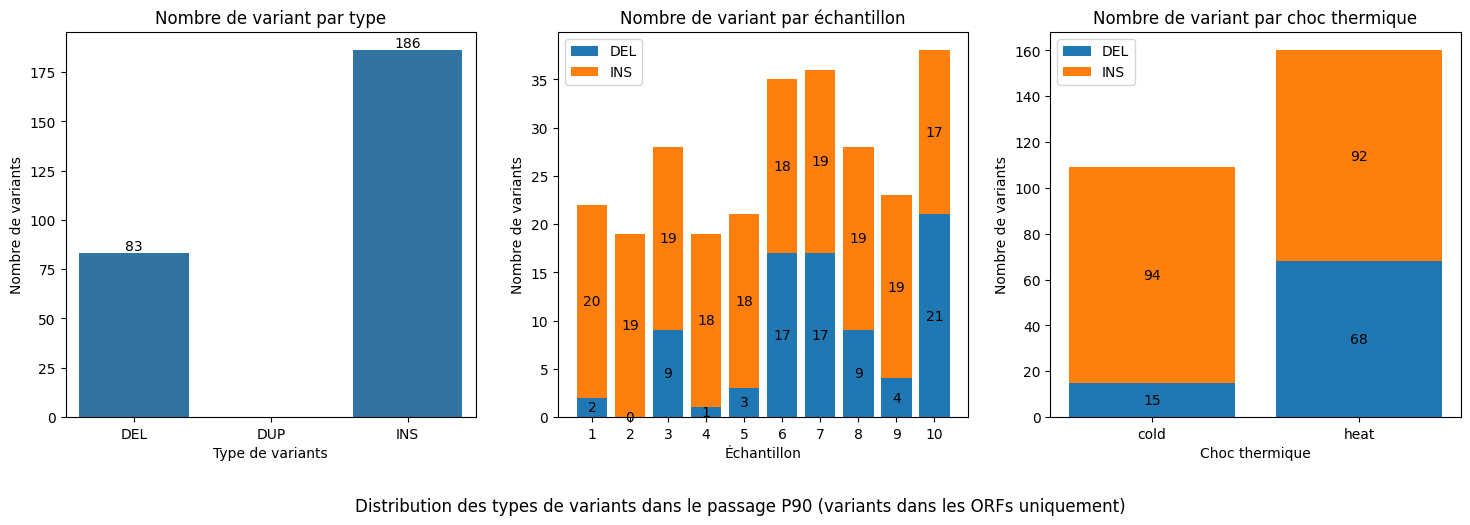

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

sns.countplot(data=data_ioi_orf, x="svtype", ax=ax1)
ax1.bar_label(container = ax1.containers[0], fontsize=10)
ax1.set_ylabel('Nombre de variants')
ax1.set_xlabel('Type de variants')
ax1.set_title(f"Nombre de variant par type")

type_count_sample = data_ioi_orf.groupby(["svtype", "sample"], observed=True).size()
bottom = np.zeros(len(samples))
for t in data_ioi_orf["svtype"].unique():
    gc = [type_count_sample[t][s] if s in type_count_sample[t] else 0 for s in samples]
    p = ax2.bar(samples, gc, label=t, bottom=bottom)
    bottom += gc
    ax2.bar_label(p, label_type='center')

ax2.set_ylabel('Nombre de variants')
ax2.set_xlabel('Échantillon')
ax2.set_xticks(samples)
ax2.set_title(f"Nombre de variant par échantillon")
ax2.legend()


type_count_choc = data_ioi_orf.groupby(["svtype", "choc"], observed=True).size()
bottom = np.zeros(len(chocs))
for t in data_ioi_orf["svtype"].unique():
    gc = [type_count_choc[t][c] if c in type_count_choc[t] else 0 for c in chocs]
    p = ax3.bar(chocs, gc, label=t, bottom=bottom)
    bottom += gc
    ax3.bar_label(p, label_type='center')

ax3.set_ylabel('Nombre de variants')
ax3.set_xlabel('Choc thermique')
ax3.set_title(f"Nombre de variant par choc thermique")
ax3.legend()

plt.suptitle(f"Distribution des types de variants dans le passage P{ioi} (variants dans les ORFs uniquement)", y=-0.05)
plt.show()
#plt.savefig("../results/figs/types_90_orf.pdf")

## Tailles et positions des variants

On veut analyser la taille des différents variants ainsi que leurs position sur le génome pour voir si il y a des régions qui se démarquent.

On note qu'il n'y a pas de différence notable de longueur entre les insertions et les délétions, ormis la délétion "géante" de l'orf25

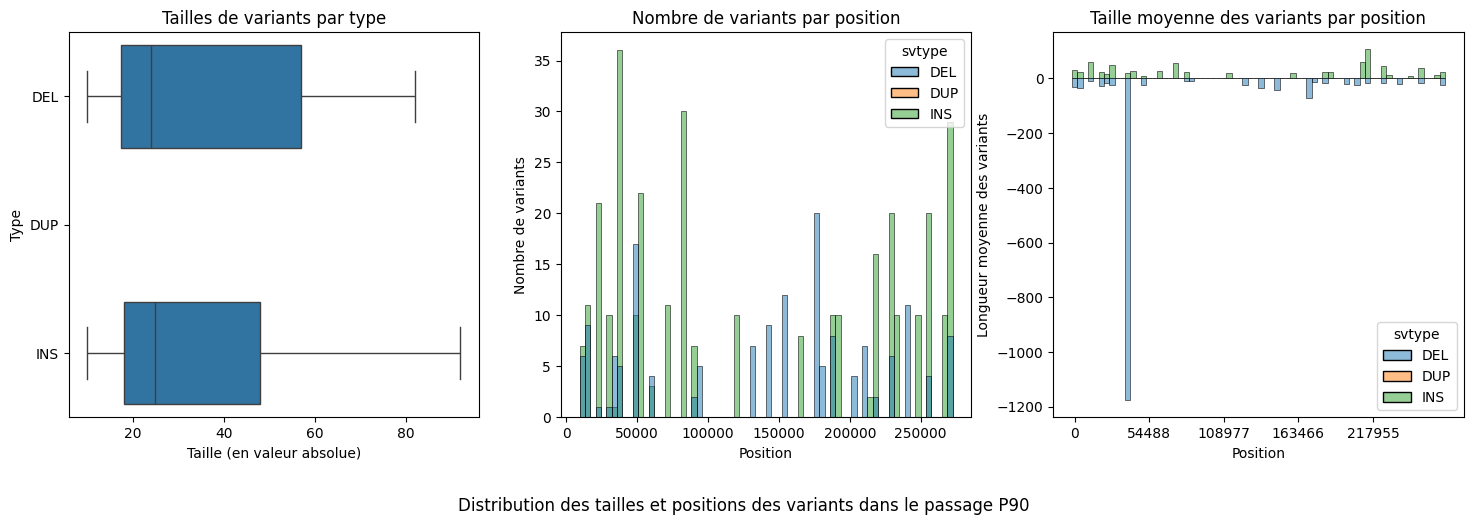

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

sns.boxplot(data=data_ioi, x=abs(data_ioi["svlen"]), y="svtype", showfliers=False, ax=ax1)
ax1.set_xlabel("Taille (en valeur absolue)")
ax1.set_ylabel("Type")
ax1.set_title("Tailles de variants par type")

nbins = 70
sns.histplot(data=data_ioi, x="pos", hue="svtype", bins=nbins, ax=ax2)
ax2.set_xlabel(f"Position")
ax2.set_ylabel("Nombre de variants")
ax2.set_title("Nombre de variants par position")
sns.move_legend(ax2, "upper right")

max_pos = max(data_ioi["pos"])
data_ioi.loc[:, 'pos_bin'] = pd.cut(data_ioi['pos'], nbins, labels=range(nbins))
data_mean_len = data_ioi.groupby(['pos_bin', 'svtype'], as_index=False, observed=True)['svlen'].mean()
sns.histplot(data=data_mean_len, x="pos_bin", hue="svtype", weights='svlen', bins=nbins, ax=ax3)
ax3.set_xlabel(f"Position")
ax3.set_ylabel("Longueur moyenne des variants")
ax3.set_xticks([i * (nbins / 5) for i in range(5)], labels=[int(i * (max_pos / 5)) for i in range(5)])
ax3.set_title("Taille moyenne des variants par position")

plt.suptitle(f"Distribution des tailles et positions des variants dans le passage P{ioi}", y=-0.05)
plt.show()
#plt.savefig("../results/figs/length_90.pdf")

In [16]:
data_ioi[(data_ioi["pos"] > 75000) & (data_ioi["pos"] < 90000)]

,pos,id,svtype,svlen,end,af,dv,dr,depth,alt,ref,sample,iteration,group,choc,period,orfs,pos_bin
973,83046,Sniffles2.INS.100S0,INS,39,83046,0.207,1016,3886,4902,AGCCGAAGCAGCCGAAGCAGCCGAAGCCACCAAACCCAA,N,2,90,329,cold,after,[CyHV3_ORF48],19
976,83046,Sniffles2.INS.121S0,INS,39,83046,0.301,733,1706,2439,AGCCGAAGCAGCCGAAGCAGCCGAAGCCACCAAACCCAA,N,3,90,329,cold,after,[CyHV3_ORF48],19
978,83046,Sniffles2.INS.D3S0,INS,39,83046,0.227,1085,3688,4773,AGCCGAAGCAGCCGAAGCAGCCGAAGCCACCAAACCCAA,N,4,90,329,cold,after,[CyHV3_ORF48],19
984,83046,Sniffles2.INS.DBS0,INS,39,83046,0.229,396,1332,1728,AGCCGAAGCAGCCGAAGCAGCCGAAGCCACCAAACCCAA,N,6,90,329,heat,after,[CyHV3_ORF48],19
987,83046,Sniffles2.INS.EBS0,INS,39,83046,0.236,435,1405,1840,AGCCGAAGCAGCCGAAGCAGCCGAAGCCACCAAACCCAA,N,7,90,329,heat,after,[CyHV3_ORF48],19
990,83046,Sniffles2.INS.11FS0,INS,39,83046,0.225,507,1742,2249,<INS>,N,8,90,329,heat,after,[CyHV3_ORF48],19
993,83046,Sniffles2.INS.105S0,INS,39,83046,0.199,733,2946,3679,<INS>,N,9,90,329,heat,after,[CyHV3_ORF48],19
1002,83046,Sniffles2.INS.FFS0,INS,39,83046,0.234,964,3160,4124,ACCAGAAGCAGCCGAAGCAGCCGAAGCAGCCGAAGC,N,1,90,334,cold,after,[CyHV3_ORF48],19
1010,83046,Sniffles2.INS.102S0,INS,84,83046,0.098,405,3719,4124,AGCCGAAGCAGCCGAAGCAGCCGAAGCAGCCGAAGCAGCCGAAGCA...,N,1,90,336,cold,after,[CyHV3_ORF48],19
1011,83046,Sniffles2.INS.124S0,INS,84,83046,0.091,223,2216,2439,<INS>,N,3,90,336,cold,after,[CyHV3_ORF48],19


Similairement, on peut répliquer ces graphiques sur les variants présent uniquement dans les ORFs

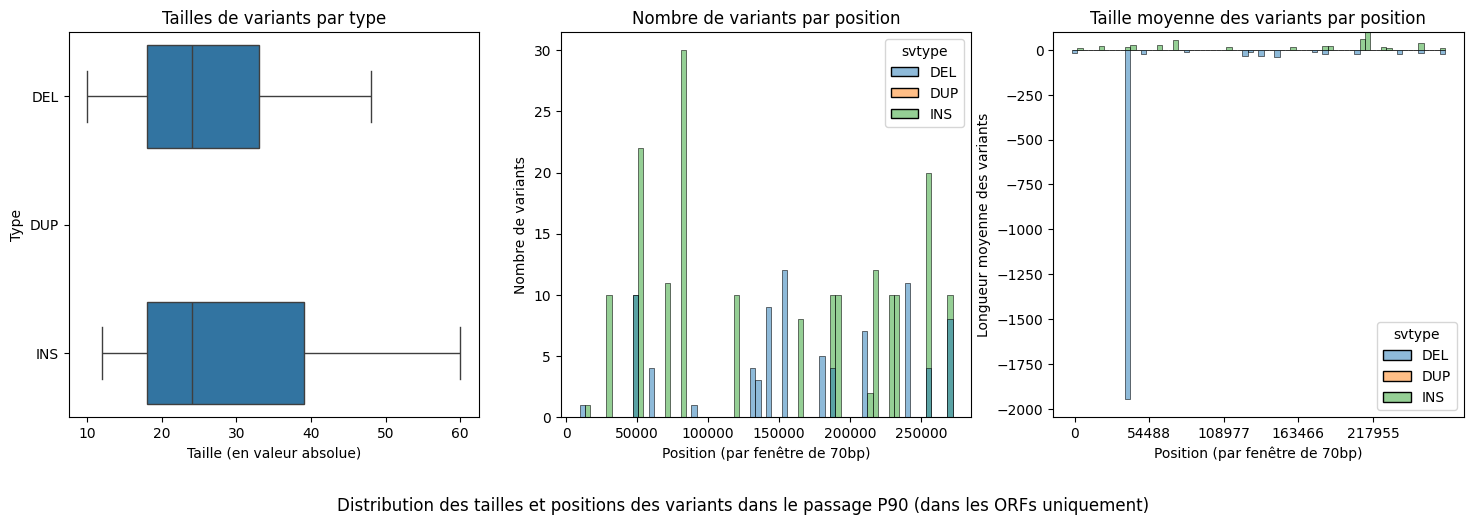

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

sns.boxplot(data=data_ioi_orf, x=abs(data_ioi_orf["svlen"]), y="svtype", showfliers=False, ax=ax1)
ax1.set_xlabel("Taille (en valeur absolue)")
ax1.set_ylabel("Type")
ax1.set_title("Tailles de variants par type")

nbins = 70
sns.histplot(data=data_ioi_orf, x="pos", hue="svtype", bins=nbins, ax=ax2)
ax2.set_xlabel(f"Position (par fenêtre de {nbins}bp)")
ax2.set_ylabel("Nombre de variants")
ax2.set_title("Nombre de variants par position")

max_pos = max(data_ioi["pos"])
data_ioi_orf.loc[:, 'pos_bin'] = pd.cut(data_ioi_orf['pos'], nbins, labels=range(nbins))
data_mean_len = data_ioi_orf.groupby(['pos_bin', 'svtype'], as_index=False, observed=True)['svlen'].mean()
sns.histplot(data=data_mean_len, x="pos_bin", hue="svtype", weights='svlen', bins=nbins, ax=ax3)
ax3.set_ylim(ax3.get_ylim()[0], 100)
ax3.set_xlabel(f"Position (par fenêtre de {nbins}bp)")
ax3.set_ylabel("Longueur moyenne des variants")
ax3.set_xticks([i * (nbins / 5) for i in range(5)], labels=[int(i * (max_pos / 5)) for i in range(5)])
ax3.set_title("Taille moyenne des variants par position")

plt.suptitle(f"Distribution des tailles et positions des variants dans le passage P{ioi} (dans les ORFs uniquement)", y=-0.05)
plt.show()

## Comparaisons entre les échantillons

### Méthode

On évalue la similarité entre échlantillons, paire à paire, pour voir si ceux ci partagent beaucoup de variations. On sait déjà des analyse précédentes que le groupe chaud possède nettement plus de délétions que le groupe froid. Cette analyse nous permet de voir si ces délétions sont uniques, ou si elles sont partagés entre les échantillons du groupe chaud : si on les retrouves en quantité significatives, nous pourrons affirmer avec un certain niveau de confiance que la présence/absence de ces mutations est belle est bien corrélé au choc thermique.

Soit $S$ la matrice de similarité, la similarité entre deux échantillons $i, j$ est donné par $S_{i, j} = S{j, i} = \frac{\text{Nombre de variants présent dans \textbf{i et j}}}{\text{Nombre de variants présents dans \textbf{i ou j}}}$

Bien que cette mesure donne une bonne idée de l'homogénéité des échantillons, il pourrait être intéressant de considérer un vrai test statistique qui serait pet être plus robuste. La principale faiblesse ici est la sensibilité à la taille des échantillons : en effet si les échantillons sont trop petits, ils sont nécéssairement moins suceptible de partager des variations, d'autant que les échantillons du groupe froid présentent moins de variations que les échantillons du groupe chaud (voir plus haut).

### Résultat

Dans la 1ère matrice on observe des valeurs plus significative au sein des groupes froid / chaud, la tendance est assez similaire.

Dans la seconde matrice on se concentre sur les variations présentent uniquement dans les ORFs. On remarque une concentration plus importante au sein des groupe que précédemment, pour les mutations qui interfère avec les ORFs, leur présence est donc plus fortement lié au choc thermique subit.

Enfin on remarque les échantillons 3 et 9 qui se démarquent nettement de leur groupe. Hypothèses:
- un autre mécanisme entre en jeu (par exemple un autre variants, plus rare à permis de contrer le potentiel effet délétaire des délétions)
- le séquencage à pu révéler des variants dans l'échantillon 3 mais pas dans les 3 autres, ce qui voudrais dire que ces variants ne serait pas nécéssairement corrélés au choc thermique, plutot un problème expérimental (échantillonage ? séquencage ?) -> regarder en détail l'échantillon 3 pour voir si il se démarque des autres (profondeur de l'alignement, distribution des variants, proportions de tags assignés, ect...)
- certains adn provenant de P90-3 ont étés échangés (ou leurs tags) avec des adn provenant de P90-9 -> qui a préparé P90-3 lol ?

In [18]:
def pairwise_similarity(sv, sv_groups, key, thresold=0):
    grouped = sv.groupby(["group"], observed=True)
    sims = np.ones(shape=(len(sv_groups), len(sv_groups)), dtype=np.float64)
    for i, s1 in enumerate(sv_groups):
        for j in range(0, i):
            s2 = sv_groups[j]
            from_i_or_j = [g for g in grouped.indices if s1 in grouped.get_group(g)[key].values or s2 in grouped.get_group(g)[key].values]
            from_i_and_j = [g for g in grouped.indices if s1 in grouped.get_group(g)[key].values and s2 in grouped.get_group(g)[key].values]
            sims[i][j] = len(from_i_and_j) / len(from_i_or_j) if len(from_i_or_j) > 0 else 0
            sims[i][j] = sims[i][j] if sims[i][j] >= thresold else 0
            sims[j][i] = sims[i][j]
    return sims

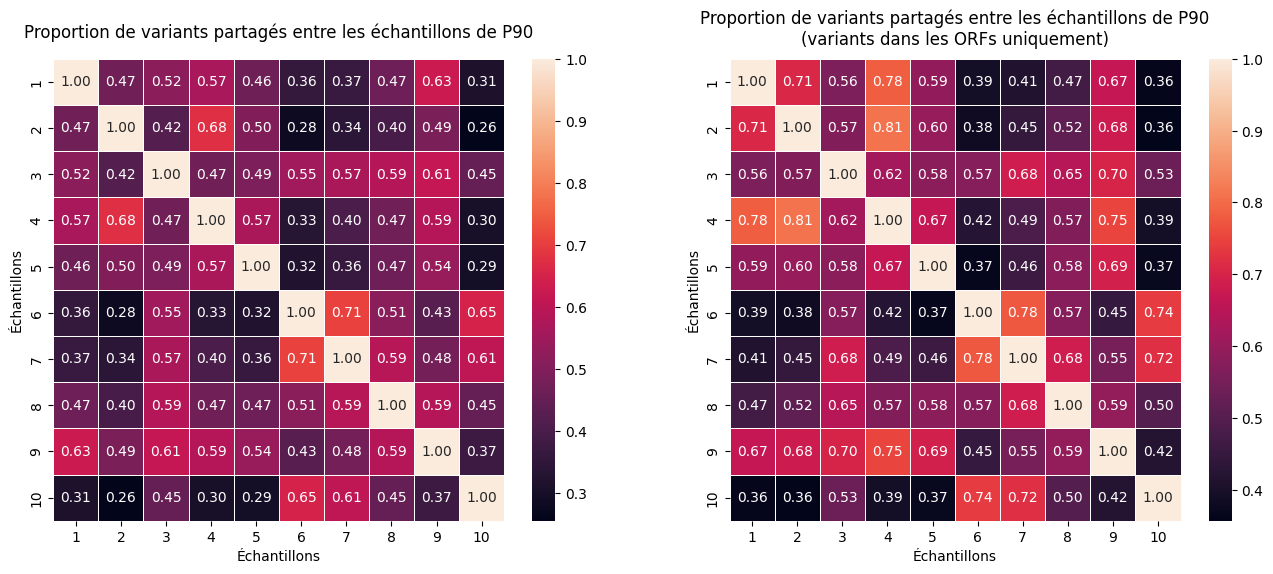

In [19]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

sim = pairwise_similarity(data_ioi, samples, "sample")
sns.heatmap(sim, annot=True, linewidth=.4, fmt=".2f", xticklabels=samples, yticklabels=samples, ax=ax1)
ax1.set_xlabel("Échantillons")
ax1.set_ylabel("Échantillons")
ax1.set_title(f"Proportion de variants partagés entre les échantillons de P{ioi}", pad=15)

sim = pairwise_similarity(data_ioi_orf, samples, "sample")
sns.heatmap(sim, annot=True, linewidth=.4, fmt=".2f", xticklabels=samples, yticklabels=samples, ax=ax2)
ax2.set_xlabel("Échantillons")
ax2.set_ylabel("Échantillons")
ax2.set_title(f"Proportion de variants partagés entre les échantillons de P{ioi}\n(variants dans les ORFs uniquement)", pad=10)

plt.show()
#plt.savefig("../results/figs/heatmap_90.pdf")

## Recherche des variants discriminants

Si des variants sont corrélés avec le choc thermique, ils ont probablement un effet significatif dans un des deux groupes. La solution la plus direct est de rechercher les variants qui sont dans des ORFs et qui ne sont présent que dans le groupe chaud ou le groupe froid. 

Cette méthode présente plusieurs inconvénients. Elle est trop restrictive et peu rater des variants présent en fréquence significativement différentes.
Par exemple si un variants et présent 1 fois dans le chaud et 5 fois dans le froid il ne sera pas détecté malgrès une différence significative, alors que si il est présent 0 fois dans le chaud et 1 fois dans le froid, il sera détecté (situation beaucoup moins significative).

Il faudrais alors mettre en place un test statistique plus robuste qui nous permette de dire si l'apparition d'une variation est corrélé avec le choc thermique (fisher ? khi2 ? ...).

Suite à cela nous avons choisis d'investiguer le variant de l'ORF78 qui semble être la plus importante.

In [20]:
uniques = data_ioi_orf.groupby(["group"], observed=True).filter(lambda x: not ("heat" in x["choc"].values and "cold" in x["choc"].values))

candidates = data[data["group"].isin(uniques["group"].unique())]
candidates.to_csv("../results/candidates_1.csv")
candidates.drop_duplicates("group")

,pos,id,svtype,svlen,end,af,dv,dr,depth,alt,ref,sample,iteration,group,choc,period,orfs
54,9457,Sniffles2.DEL.1D5S0,DEL,-17,9474,0.594,899,614,1513,N,TCAGGACACTACCATGT,10,90,17,heat,after,[CyHV3_ORF5_1]
140,15501,Sniffles2.INS.35S0,INS,12,15501,1.000,7594,0,7594,TCATCATCATCA,N,9,90,41,heat,after,[CyHV3_ORF7_1]
733,47346,Sniffles2.DEL.2D2S0,DEL,-1850,49196,0.490,979,1020,1999,N,TTCGGGGCCCAGGTTTCCCGGAGGCCCTAAAACACTATAGCGGGCG...,7,90,279,heat,after,"[CyHV3_ORF25, CyHV3_ORF26, CyHV3_ORF27]"
864,60281,Sniffles2.DEL.4AES0,DEL,-25,60306,0.547,203,168,371,N,GTATAGACCCGCGTCTCTCGCCAGA,1,15,300,cold,before,[CyHV3_ORF40]
924,69696,Sniffles2.INS.DFS0,INS,17,69696,0.086,194,2054,2248,<INS>,N,2,65,306,cold,after,[CyHV3_ORF43]
1002,83046,Sniffles2.INS.FFS0,INS,39,83046,0.234,964,3160,4124,ACCAGAAGCAGCCGAAGCAGCCGAAGCAGCCGAAGC,N,1,90,334,cold,after,[CyHV3_ORF48]
1020,83046,Sniffles2.INS.103S0,INS,84,83046,0.097,475,4427,4902,CGAAGCAGCCGAAGCAGCCGAAGCAGCCGAAGCAGCCGAAGCAGCC...,N,2,90,339,cold,after,[CyHV3_ORF48]
1029,83046,Sniffles2.INS.ECS0,INS,39,83046,0.196,723,2964,3687,AAGCAGACGAAGCGAACAACAACAACGGCCACCAAACCC,N,5,90,348,cold,after,[CyHV3_ORF48]
1032,83046,Sniffles2.INS.DES0,INS,84,83046,0.068,118,1610,1728,AGCAGCCGAAGCAGCCGAAGCAGCCGAAGCAGCCGAAGCAGCCGAA...,N,6,90,351,heat,after,[CyHV3_ORF48]
1038,83046,Sniffles2.INS.9ES0,INS,39,83046,0.225,208,717,925,ACCAGAGCAGCCGAAGCAGCCGGAGACGA,N,10,90,357,heat,after,[CyHV3_ORF48]


## Évolution des variants candidats au fil des passages

In [21]:
def plot_variant(freqs, ax):
    cold_colors = plt.cm.Blues(np.linspace(0.4, 0.8, 5))
    warm_colors = plt.cm.Reds(np.linspace(0.4, 0.8, 5))
    
    for i in range(10):
        if i < 5:
            sns.lineplot(data=freqs[i], label=f'{i+1}', color=cold_colors[i], ax=ax)
        else:
            sns.lineplot(data=freqs[i], label=f'{i+1}', color=warm_colors[i-5], ax=ax)
    
    ax.set_xlabel("Passages (P15 à P90)")
    ax.set_xticks(list(range(5)), labels=["P15", "P30", "P50", "P65", "P90"])
    ax.set_ylabel("Fréquence allélique (en %)")
    ax.legend(title="Sample")

Text(0.5, 1.0, "Évolution du variant numéro 447\nDans les orfs ['CyHV3_ORF78']")

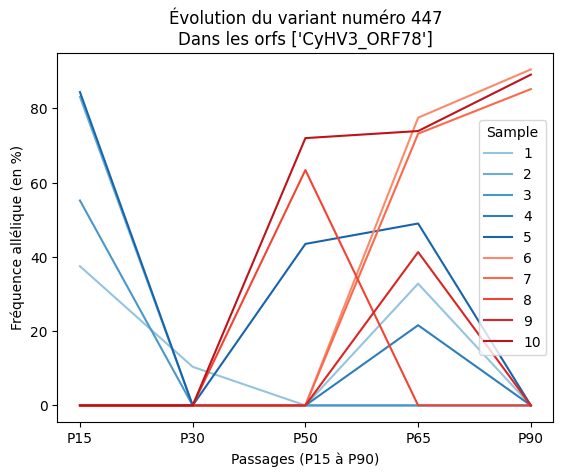

In [22]:
variant = 447

group = data[data["group"] == variant]
freqs = np.zeros(shape=(10, 5))
for _, x in group.iterrows():
    index = 0
    if x["iteration"] == 30:
        index = 1
    if x["iteration"] == 50:
        index = 2
    elif x["iteration"] == 65:
        index = 3
    if x["iteration"] == 90:
        index = 4
    
    freqs[x["sample"] - 1, index] = x["af"] * 100

fig, ax = plt.subplots()
plot_variant(freqs, ax)
ax.set_title(f"Évolution du variant numéro {variant}\nDans les orfs {group.iloc[0]["orfs"]}")

# Analyse de l'échantillon 10

**Remarque :** Cette analyse peut être lancé sur n'importe quel échantillon en modifiant la variable **soi** ci dessous.

On veux comparer les différent passages d'un même échantillon pour voir si il y a un évolution particulière dans la distribution des variants.
C'est quasi identique à l'anlayse précédente, on compare les passage d'un échantillon donné au lieu de comparer les échantillons d'un passage donc je ne vais pas trop rentrer dans les détails

In [23]:
soi = 10
data_soi = data[data["sample"] == soi]
data_soi_orf = data_soi[data_soi["orfs"].astype(bool)]

## Distribution des variants

On compte le nombre de variant par type dans tous les passages de l'échantillon 10 (P15-10 à P90-10).
Sur le 2ème plot on compte par passage, et sur le 3ème plot on distingue avant ( \< P30 ) et après (\>= P30) le choc.

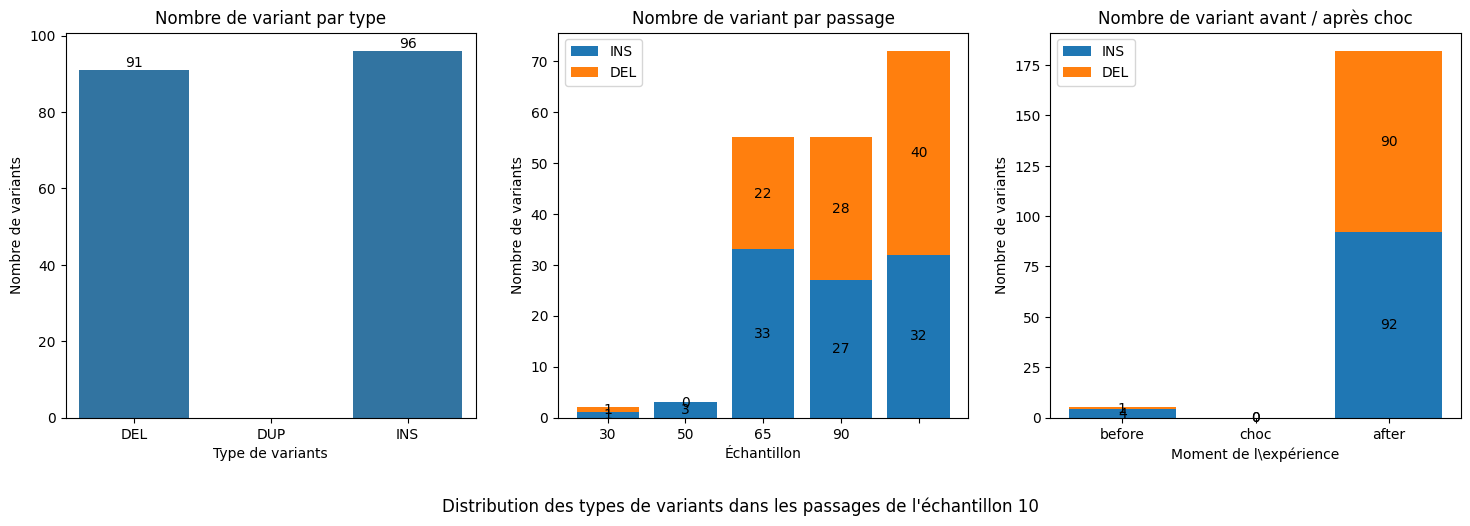

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

sns.countplot(data=data_soi, x="svtype", ax=ax1)
ax1.bar_label(container = ax1.containers[0], fontsize=10)
ax1.set_ylabel('Nombre de variants')
ax1.set_xlabel('Type de variants')
ax1.set_title(f"Nombre de variant par type")

type_count_sample = data_soi.groupby(["svtype", "iteration"], observed=True).size()
bottom = np.zeros(len(iterations))
for t in data_soi["svtype"].unique():
    gc = [type_count_sample[t][i] if i in type_count_sample[t] else 0 for i in iterations]
    p = ax2.bar(range(len(iterations)), gc, label=t, bottom=bottom)
    bottom += gc
    ax2.bar_label(p, label_type='center')

ax2.set_ylabel('Nombre de variants')
ax2.set_xlabel('Échantillon')
ax2.set_xticklabels([0] + iterations)
ax2.set_title(f"Nombre de variant par passage")
ax2.legend()


data_soi["period"] = data_soi.apply(lambda x: "before" if x["iteration"] <= 30 else "after", axis=1)
type_count_time = data_soi.groupby(["svtype", "period"], observed=True).size()
bottom = np.zeros(len(periods))
for t in data_soi["svtype"].unique():
    gc = [type_count_time[t][p] if p in type_count_time[t] else 0 for p in periods]
    p = ax3.bar(periods, gc, label=t, bottom=bottom)
    bottom += gc
    ax3.bar_label(p, label_type='center')

ax3.set_ylabel('Nombre de variants')
ax3.set_xlabel('Moment de l\expérience')
ax3.set_title(f"Nombre de variant avant / après choc")
ax3.legend()

plt.suptitle(f"Distribution des types de variants dans les passages de l'échantillon {soi}", y=-0.05)
plt.show()

On réitère avec les variant qui chevauchent des ORFs

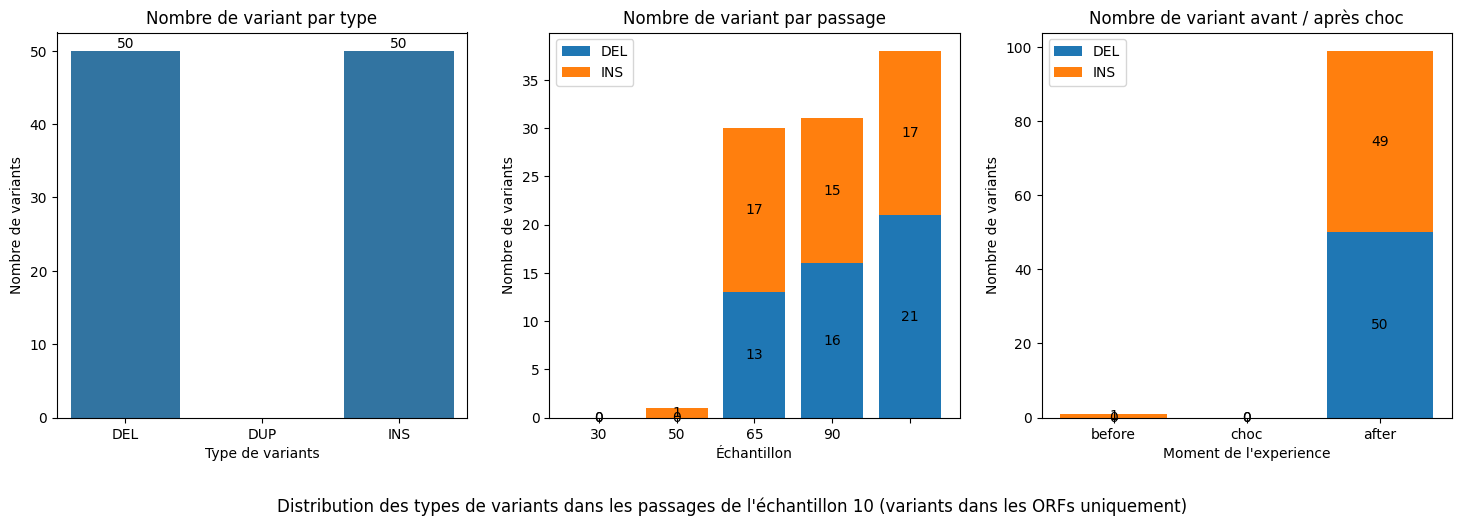

In [25]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

sns.countplot(data=data_soi_orf, x="svtype", ax=ax1)
ax1.bar_label(container = ax1.containers[0], fontsize=10)
ax1.set_ylabel('Nombre de variants')
ax1.set_xlabel('Type de variants')
ax1.set_title(f"Nombre de variant par type")

type_count_sample = data_soi_orf.groupby(["svtype", "iteration"], observed=True).size()
bottom = np.zeros(len(iterations))
for t in data_soi_orf["svtype"].unique():
    gc = [type_count_sample[t][i] if i in type_count_sample[t] else 0 for i in iterations]
    p = ax2.bar(range(len(iterations)), gc, label=t, bottom=bottom)
    bottom += gc
    ax2.bar_label(p, label_type='center')

ax2.set_ylabel('Nombre de variants')
ax2.set_xlabel('Échantillon')
ax2.set_xticklabels([0] + iterations)
ax2.set_title(f"Nombre de variant par passage")
ax2.legend()


data_soi_orf["period"] = data_soi_orf.apply(lambda x: "before" if x["iteration"] <= 30 else "after", axis=1)
type_count_time = data_soi_orf.groupby(["svtype", "period"], observed=True).size()
bottom = np.zeros(len(periods))
for t in data_soi_orf["svtype"].unique():
    gc = [type_count_time[t][p] if p in type_count_time[t] else 0 for p in periods]
    p = ax3.bar(periods, gc, label=t, bottom=bottom)
    bottom += gc
    ax3.bar_label(p, label_type='center')

ax3.set_ylabel('Nombre de variants')
ax3.set_xlabel('Moment de l\'experience')
ax3.set_title(f"Nombre de variant avant / après choc")
ax3.legend()

plt.suptitle(f"Distribution des types de variants dans les passages de l'échantillon {soi} (variants dans les ORFs uniquement)", y=-0.05)
plt.show()

## Tailles et positions des variants

Dans l'ensemble des passages de l'échantillon 10, on mesure la taille des variants et leur répartition le long du génome.

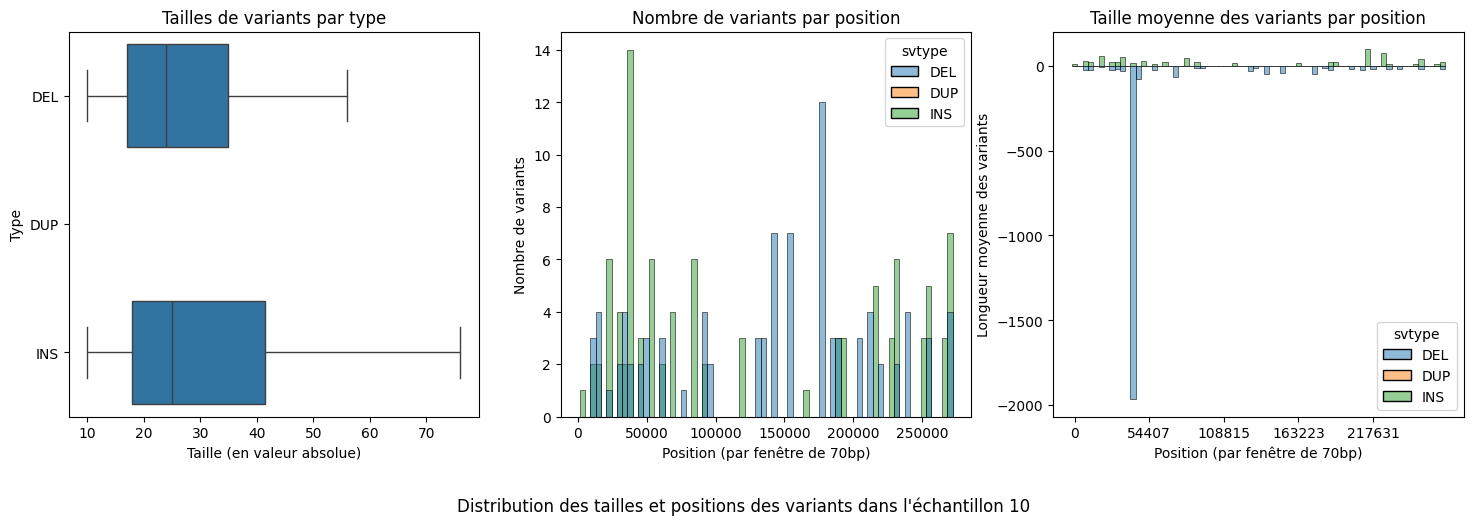

In [26]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

sns.boxplot(data=data_soi, x=abs(data_soi["svlen"]), y="svtype", showfliers=False, ax=ax1)
ax1.set_xlabel("Taille (en valeur absolue)")
ax1.set_ylabel("Type")
ax1.set_title("Tailles de variants par type")

nbins = 70
sns.histplot(data=data_soi, x="pos", hue="svtype", bins=nbins, ax=ax2)
ax2.set_xlabel(f"Position (par fenêtre de {nbins}bp)")
ax2.set_ylabel("Nombre de variants")
ax2.set_title("Nombre de variants par position")

max_pos = max(data_soi["pos"])
data_soi.loc[:, 'pos_bin'] = pd.cut(data_soi['pos'], nbins, labels=range(nbins))
data_mean_len = data_soi.groupby(['pos_bin', 'svtype'], as_index=False, observed=True)['svlen'].mean()
sns.histplot(data=data_mean_len, x="pos_bin", hue="svtype", weights='svlen', bins=nbins, ax=ax3)
ax3.set_xlabel(f"Position (par fenêtre de {nbins}bp)")
ax3.set_ylabel("Longueur moyenne des variants")
ax3.set_xticks([i * (nbins / 5) for i in range(5)], labels=[int(i * (max_pos / 5)) for i in range(5)])
ax3.set_title("Taille moyenne des variants par position")

plt.suptitle(f"Distribution des tailles et positions des variants dans l'échantillon {soi}", y=-0.05)
plt.show()

On réitère en filtrant les variants dans des ORFs

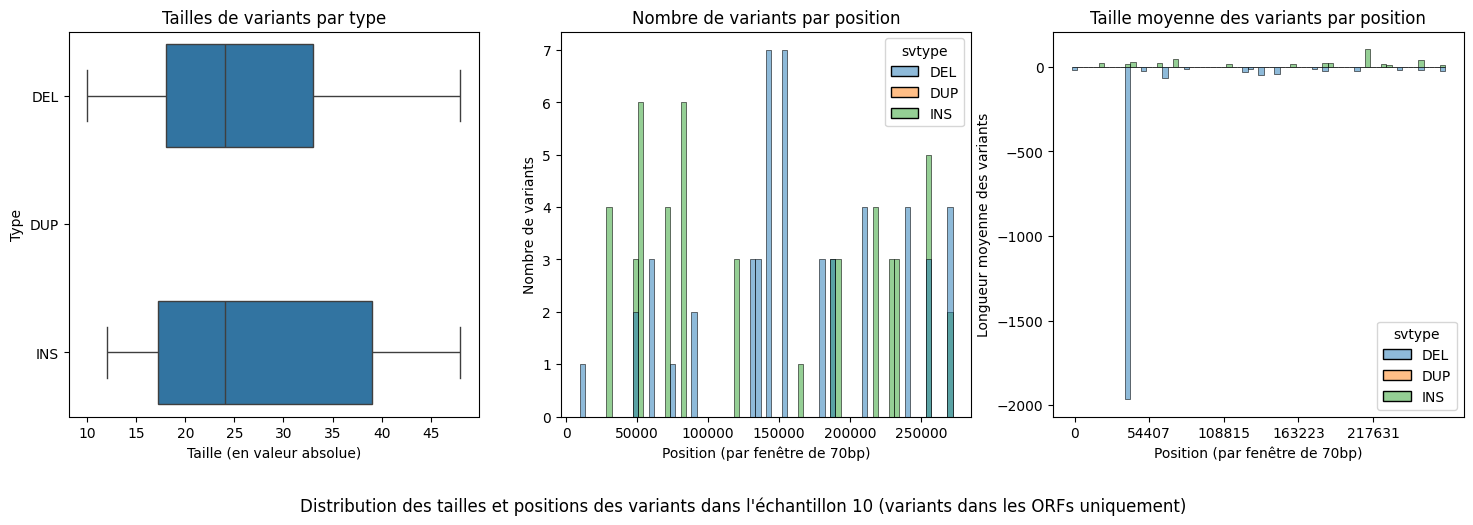

In [27]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

sns.boxplot(data=data_soi_orf, x=abs(data_soi_orf["svlen"]), y="svtype", showfliers=False, ax=ax1)
ax1.set_xlabel("Taille (en valeur absolue)")
ax1.set_ylabel("Type")
ax1.set_title("Tailles de variants par type")

nbins = 70
sns.histplot(data=data_soi_orf, x="pos", hue="svtype", bins=nbins, ax=ax2)
ax2.set_xlabel(f"Position (par fenêtre de {nbins}bp)")
ax2.set_ylabel("Nombre de variants")
ax2.set_title("Nombre de variants par position")

max_pos = max(data_soi_orf["pos"])
data_soi_orf.loc[:, 'pos_bin'] = pd.cut(data_soi_orf['pos'], nbins, labels=range(nbins))
data_mean_len = data_soi_orf.groupby(['pos_bin', 'svtype'], as_index=False, observed=True)['svlen'].mean()
sns.histplot(data=data_mean_len, x="pos_bin", hue="svtype", weights='svlen', bins=nbins, ax=ax3)
ax3.set_xlabel(f"Position (par fenêtre de {nbins}bp)")
ax3.set_ylabel("Longueur moyenne des variants")
ax3.set_xticks([i * (nbins / 5) for i in range(5)], labels=[int(i * (max_pos / 5)) for i in range(5)])
ax3.set_title("Taille moyenne des variants par position")

plt.suptitle(f"Distribution des tailles et positions des variants dans l'échantillon {soi} (variants dans les ORFs uniquement)", y=-0.05)
plt.show()

## Similarité entre les passages

Mesure de similarité par paire de passage.

On remarque bien ici une différence entre avant le choc et après le choc (cependant on voit précedemment qu'il y a très peu de variants avants le choc donc attention aux potentiel biais)

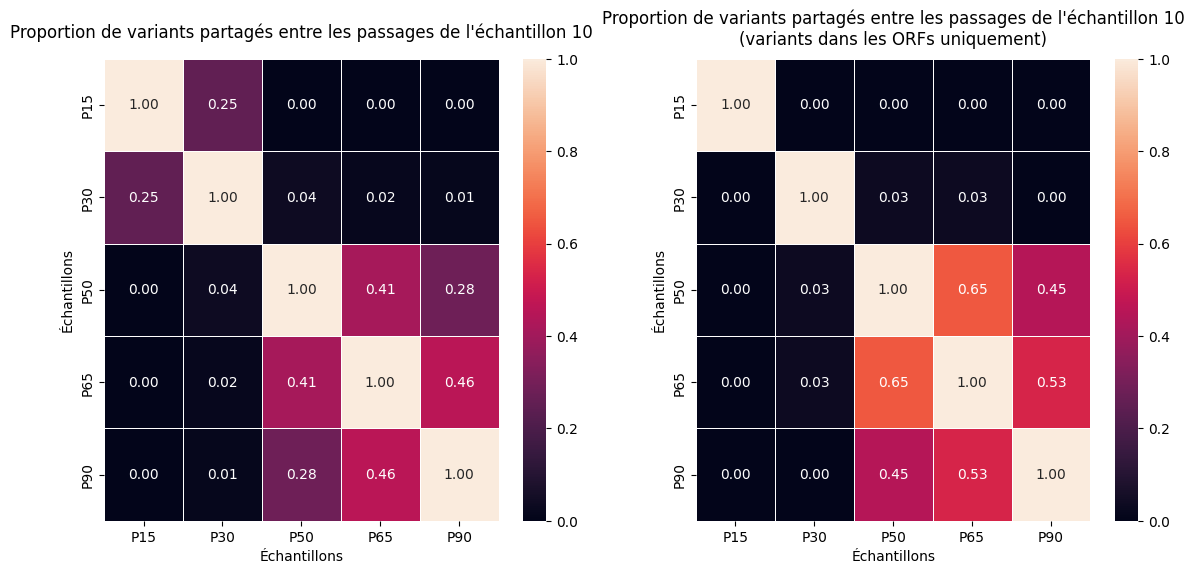

In [28]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

iter_labels = [f"P{i}" for i in iterations]

sim = pairwise_similarity(data_soi, iterations, "iteration")
sns.heatmap(sim, annot=True, linewidth=.4, fmt=".2f", xticklabels=iter_labels, yticklabels=iter_labels, ax=ax1)
ax1.set_xlabel("Échantillons")
ax1.set_ylabel("Échantillons")
ax1.set_title(f"Proportion de variants partagés entre les passages de l'échantillon {soi}", pad=15)

sim = pairwise_similarity(data_soi_orf, iterations, "iteration")
sns.heatmap(sim, annot=True, linewidth=.4, fmt=".2f", xticklabels=iter_labels, yticklabels=iter_labels, ax=ax2)
ax2.set_xlabel("Échantillons")
ax2.set_ylabel("Échantillons")
ax2.set_title(f"Proportion de variants partagés entre les passages de l'échantillon {soi}\n(variants dans les ORFs uniquement)", pad=10)

ax2.plot([5.05, 5.05], [5.05, 9.97], 'r-', lw=3)
ax2.plot([9.95, 9.95], [5.05, 9.97], 'r-', lw=3)
ax2.plot([5.05, 9.95], [9.97, 9.97], 'r-', lw=3)
ax2.plot([5.05, 9.95], [5.05, 5.05], 'r-', lw=3)

plt.show()

# Perspectives

- test d'homogénéité formel pour comparer deux ensembles de variants
- test de corrélation formel pour déterminer si:
    - l'apparition d'un variant est corrélé avec le choc thermique -> on peut soit comparer les échantillons 1-5 vs 6-10 dans chaque passage, soit comparer le passage 30 vs les autres pour chaque échantillons, ...
    - la corrélation entre la présence absence de 2 variants pour déterminer si ils ont des effets complémentaires
- il s'agit de pouvoir réaliser l'analyse qui à ici été faite graphiquement, de facon statistique avec des métrique plus facilement interprétables
- investiguer échantillons 3 et 9
- considérer un seuil de similarité entre échantillon plus faible pour les considérer identiques (100% pour le moment)
- le choc thermique peut il être à la source de l'apparition / la disparition d'un variant ? plus dans le chaud ou dans le froid ?
